# Assess the WOA09 T/S vertical smoothing where static instabilities arise in CREG025.L75 experiments

In [114]:
import xarray as xr
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
from fsspec.implementations.local import LocalFileSystem
fs = LocalFileSystem()

%matplotlib inline

>> Function definition START

In [115]:
def Arc_Bat(ztype='isol1000') :

        locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/'
        locfile='bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc'
        fieldbat=Dataset(locpath+locfile)
        lon  = np.squeeze(fieldbat.variables['nav_lon'])
        lat  = np.squeeze(fieldbat.variables['nav_lat'])
        My_var = np.squeeze(fieldbat.variables['Bathymetry'])

        spval = 0.
        My_var= np.ma.masked_where(My_var <= spval,My_var)

        if ztype == 'isol1000' :
                vmin=1000. ; vmax=2000.
                contours=[1000.]
                limits=[vmin,vmax]
                myticks=[1000.]
        elif ztype == 'isol1500' :
                vmin=1500. ; vmax=2000.
                contours=[1500.]
                limits=[vmin,vmax]
                myticks=[1500.]
        elif ztype == 'isomonarc' :
                vmin=500. ; vmax=4000.
                contours=[500.,2000.,4000.]
                limits=[vmin,vmax]
                myticks=[500.,2000.,4000.]
        elif ztype == 'isol500' :
                vmin=500. ; vmax=500.
                contours=[500.]
                limits=[vmin,vmax]
                myticks=[500.]
        else:
                vmin=0. ; vmax=8000.
                contours=[100.,500.,1000.,2000.,3000.,3500.,4000.]
                limits=[vmin,vmax]
                myticks=[100.,500.,1000.,2000.,3000.,3500.,4000.]

        #
        #rcParams['text.latex.unicode']=True
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        pal = plt.cm.get_cmap('binary')
        X,Y = m(lon,lat)

        # contour (optional)
        CS2 = m.contour(X, Y, My_var, linewidths=0.5,levels=contours, colors='black', alpha=1.)
        plt.clabel(CS2, CS2.levels, inline=True, fmt='%.0f', fontsize=3)

        return m, X, Y


In [116]:
def Arc_plot(lon,lat,tab,contours,limits,myticks=None,name=None,zmy_cblab=None,zmy_cmap=None,filename='test.pdf',zvar=None):
        #
# Les 2 lignes suivantes posent un probleme a l'execution lie a LaTex ....
#       rcParams['text.usetex']=True
#       rcParams['text.latex.unicode']=True
        #rcParams['font.family']='serif'

        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')

        if zvar == 'sivolu' or zvar == 'siconc'  or zvar == 'ssh' or zvar == 'socurl' :
                zfontsize=10.
        else:
                zfontsize=6.

        if zvar != 'Bathy' :
                m.drawparallels(np.arange(-90.,91.,5.),labels=[False,False,False,False], size=zfontsize, linewidth=0.3)
                m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True], size=zfontsize, latmax=90.,linewidth=0.3)
                m.fillcontinents(color='grey',lake_color='white')

        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

        if zmy_cmap != None :
                pal = zmy_cmap
        else:
                pal = plt.cm.get_cmap('coolwarm')
                #pal = plt.cm.get_cmap('terrain')

        X,Y = m(lon,lat)
        C = m.contourf(X,Y,tab,contours,cmap=pal,norm=norm,extend='both')
        if zvar == 'ssh':
                CS=m.contour(X, Y, tab, linewidths=0.5, levels=npy.arange(limits[0],limits[1],5.), colors='k', alpha=0.4)

        ############################################################################################################
        ############################################################################################################
        moorplot=1
        if moorplot == 1 :
                bx_ARCB={'name':'B'  ,'lon_min':-150.,'lon_max':-150.,'lat_min':78.,'lat_max':78.}
                bx_ARCM={'name':'M1' ,'lon_min': 125.,'lon_max': 125.,'lat_min':78.,'lat_max':78.}
                bx_EURA={'name':'EUR','lon_min':  60.,'lon_max':  60.,'lat_min':85.,'lat_max':85.}

                All_box=[bx_ARCB,bx_EURA]
                for box in All_box:
                        lats = [box['lat_min'],box['lat_max']]
                        lons = [box['lon_min'],box['lon_max']]
                        x,y = m(lons,lats)
                        m.scatter(x,y,3,marker='o', color='r')
                        #m.plot(x,y,linewidth=2, color='g')
        ############################################################################################################
        ############################################################################################################

        # colorbar      
        if myticks is None:
                cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8)
        else:
                if zvar == 'votemper' or zvar == 'vosaline' or zvar == 'sivolu' :
                        cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8,drawedges=True)
                else:
                        cbar = plt.colorbar(C,format='%.0f',orientation='vertical',shrink=0.8,drawedges=True)

                cbar.set_label(zmy_cblab,fontsize=zfontsize)
                cl = plt.getp(cbar.ax, 'ymajorticklabels')
                plt.setp(cl, fontsize=zfontsize)

        plt.title(name,fontsize=zfontsize)

        return

In [117]:
def awtmax_depth (temp,sal,zdim,deptht,ztime=None, zmask=None):
    #%%time 
    #if ztime != None : 
    mask = (sal > 33.5) 
    ztemp = temp.where(mask)

    #%%time 
    temp_filled = (ztemp.fillna(-10)).compute() #replace nans with absurd temperature values
    depth_map = temp_filled.argmax(dim=zdim,skipna=True) 
    temp_map = temp_filled.max(dim=zdim,skipna=True)

    temp_map=temp_map.where(temp_map != -10)
    depth_map=depth_map.where(depth_map != -10)
    #print(zmask.shape)
    if zmask.any != None : depth_map=depth_map.where(zmask != 0)
    
    # Need to get now the true depth, not the index
    ind_awdepth=np.int32(depth_map)
    new_depth=[]
    for it in ind_awdepth.flat:
        if it < 0 :
            new_depth.append(-999)
        else:
            new_depth.append(deptht[it])

    true_depth=np.array(new_depth)
    true_depth=np.where(true_depth == -999,np.nan, true_depth)
    # Hard coded dimensions of the CREG12.L75 configuration 
    #reshape_true_depth=np.reshape(true_depth,(1801, 1580))
    # Hard coded dimensions of the CREG025.L75 configuration 
    if ztime != None : 
        reshape_true_depth=np.reshape(true_depth,(ztime,603, 528))
        # Transform the numpy array into a data array
        final_true_depth=xr.DataArray(reshape_true_depth,dims=['time_counter','y','x'])
    else: 
        reshape_true_depth=np.reshape(true_depth,(603, 528))
        # Transform the numpy array into a data array
        final_true_depth=xr.DataArray(reshape_true_depth,dims=['y','x'])

    
    return temp_map, final_true_depth

In [118]:
def ArcticZoom_map(zyear,infld,zmy_min=-10,zmy_max=10,CASE=None,zmap='Spectral_r'):
    # Plot the 12 months of a given year 

    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        if i < 9: 
            mm='0'+str(i+1) 
        else : 
            mm=str(i+1)
        infld.isel(time_counter=i).isel(y=slice(300,550),x=slice(200,400)).plot(ax=ax,vmin=zmy_min,vmax=zmy_max,cmap=zmap)   
        #ds_ICE['siconc'].sel(time_counter=str(year)+'-'+mm).isel(y=slice(300,550),x=slice(200,400))[0,:,:].plot.contour(ax=ax,levels=[0.15],colors='g')   
        fieldbat['bathy_meter'].isel(t=0,y=slice(300,550),x=slice(200,400)).plot.contour(ax=ax,levels=[500.,2000.],colors='k',alpha=0.8)
        # The indices in the following are taken in the new framework set by the slices just above
        zbx_SVAL={'name':'SVA','lon_min':125,'lon_max':125,'lat_min':50,'lat_max':50}
        zbx_BANN={'name':'BAN','lon_min':147,'lon_max':147,'lat_min':100,'lat_max':100}
        zbx_AANN={'name':'AAN','lon_min':154,'lon_max':154,'lat_min':125,'lat_max':125}
        zbx_KARA={'name':'KAR','lon_min':155,'lon_max':155,'lat_min':150,'lat_max':150}
        zbx_ULAP={'name':'ULA','lon_min':164,'lon_max':164,'lat_min':178,'lat_max':178}
        zbx_LAPT={'name':'LAP','lon_min':155,'lon_max':155,'lat_min':200,'lat_max':200}
        zbx_BGYR={'name':'LAP','lon_min':10,'lon_max':10,'lat_min':175,'lat_max':175}
        All_box=[zbx_SVAL,zbx_BANN,zbx_AANN,zbx_KARA,zbx_ULAP,zbx_LAPT,zbx_BGYR]
        for box in All_box:
            ax.scatter(box['lon_min'],box['lat_min'],20,marker='o', color='r')

        ax.set_title(CASE+'  month:'+str(zyear)+mm)
    return

In [119]:
# Define a function used to clean data from the Monitoring 
def clean_AM_AWtmax_depth(fldtoclean,tmask2D):
    fldtoclean=xr.where(tmask2D==0., np.nan,fldtoclean)
    fldtoclean=xr.where(fldtoclean >=999., np.nan,fldtoclean)
    return fldtoclean

>> Function definition END

# CREG025.L75  Grid

In [120]:
GRIDPATH='/home1/scratch/ctalandi/CREG025.L75/CREG025.L75-I/'
ds_grd=xr.open_dataset(GRIDPATH+'CREG025.L75_byte_mask.nc')
ds_grd
tmask2D=ds_grd['tmask'].isel(z=0,t=0)

In [121]:
locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/GRID/'
locfile='CREG025.L75_domain_cfg.nc'
ds_cfg=xr.open_dataset(locpath+locfile)

In [71]:
ds_cfg

<xarray.Dataset>
Dimensions:       (t: 1, x: 528, y: 603, z: 75)
Dimensions without coordinates: t, x, y, z
Data variables:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    jpiglo        int32 ...
    jpjglo        int32 ...
    jpkglo        int32 ...
    jperio        int32 ...
    ln_zco        int32 ...
    ln_zps        int32 ...
    ln_sco        int32 ...
    ln_isfcav     int32 ...
    glamt         (t, y, x) float64 ...
    glamu         (t, y, x) float64 ...
    glamv         (t, y, x) float64 ...
    glamf         (t, y, x) float64 ...
    gphit         (t, y, x) float64 ...
    gphiu         (t, y, x) float64 ...
    gphiv         (t, y, x) float64 ...
    gphif         (t, y, x) float64 ...
    e1t           (t, y, x) float64 ...
    e1u           (t, y, x) float64 ...
    e1v           (t, y, x) float64 ...
    e1f           (t, y, x) float64 ...
    e2t           (t, y, x) fl

# Read the initial state based on WOA09

In [122]:
PATHIN='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-I/'

# There is a problem with coordinates and dimensions name in these files,
# nav_lat is named y, nav_lon = x and dimensions are x & y, and xarray is not able to manage this
# That is why we are using basic Dataset from NetCDF4 lib 
ds_woa09=Dataset(PATHIN+'CREG025.L75-NEMO420_OCEinit_gridT.nc')
ds_woa09_sm5=Dataset(PATHIN+'CREG025.L75-NEMO420DIN_OCEinit_gridT_SM5.nc')
ds_woa09_sm10=Dataset(PATHIN+'CREG025.L75-NEMO420DIN_OCEinit_gridT_SM10.nc')

ds_woa09_full=xr.Dataset()
ds_woa09_full['votemper']=(('z','y','x'),ds_woa09['votemper'][0,:,:,:])
ds_woa09_full['vosaline']=(('z','y','x'),ds_woa09['vosaline'][0,:,:,:])
ds_woa09_full['votemper_sm5']=(('z','y','x'),ds_woa09_sm5['votemper'][0,:,:,:])
ds_woa09_full['vosaline_sm5']=(('z','y','x'),ds_woa09_sm5['vosaline'][0,:,:,:])
ds_woa09_full['votemper_sm10']=(('z','y','x'),ds_woa09_sm10['votemper'][0,:,:,:])
ds_woa09_full['vosaline_sm10']=(('z','y','x'),ds_woa09_sm10['vosaline'][0,:,:,:])
ds_woa09_full.coords['deptht']=(('z'),ds_woa09['nav_lev'])
ds_woa09_full.coords['nav_lat']=(('y','x'),ds_woa09['y'])
ds_woa09_full.coords['nav_lon']=(('y','x'),ds_woa09['x'])

In [123]:
vosaline=ds_woa09_full['vosaline']
votemper=ds_woa09_full['votemper']
votemper5=ds_woa09_full['votemper_sm5']
vosaline5=ds_woa09_full['vosaline_sm5']
vosaline10=ds_woa09_full['vosaline_sm10']
votemper10=ds_woa09_full['votemper_sm10']

In [10]:
ds_woa09_full

<xarray.Dataset>
Dimensions:        (x: 528, y: 603, z: 75)
Coordinates:
    deptht         (z) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    nav_lat        (y, x) float32 25.359825 25.359877 25.359926 ... 0.0 0.0 0.0
    nav_lon        (y, x) float32 -93.75031 -93.50031 -93.25032 ... 0.0 0.0 0.0
Dimensions without coordinates: x, y, z
Data variables:
    votemper       (z, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vosaline       (z, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    votemper_sm5   (z, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vosaline_sm5   (z, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    votemper_sm10  (z, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vosaline_sm10  (z, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

# Compute the corresponding AWTmax & depth 

In [124]:
temp_map, depth_map = awtmax_depth(votemper,vosaline,'z',np.array(ds_woa09_full['deptht']),zmask=tmask2D)
temp_map5, depth_map5 = awtmax_depth(votemper5,vosaline5,'z',np.array(ds_woa09_full['deptht']),zmask=tmask2D)
temp_map10, depth_map10 = awtmax_depth(votemper10,vosaline10,'z',np.array(ds_woa09_full['deptht']),zmask=tmask2D)

Text(0.5, 1.0, 'WOA09 AWTmax depth')

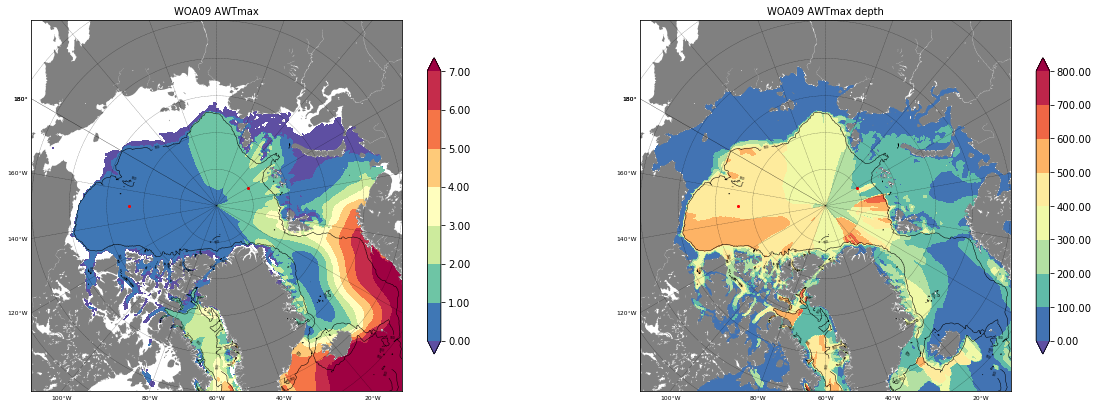

In [154]:
plt.figure(figsize=(20,15))

plt.subplot(221)
lcnt=8.  ; cnt=1.
vmin=0. ; vmax=7.
contours=np.arange(lcnt)*cnt+vmin
limits=[vmin,vmax]

Arc_Bat(ztype='isol500')
m=Arc_plot(np.array(ds_woa09_full.nav_lon),np.array(ds_woa09_full.nav_lat),np.array(temp_map),\
           contours,limits,zmy_cblab=contours,zmy_cmap='Spectral_r')
plt.title('WOA09 AWTmax',fontsize=10)

plt.subplot(222)
lcnt=9 ; cnt=100
vmin=0. ; vmax=800.
contours=np.arange(lcnt)*cnt+vmin
limits=[vmin,vmax]

Arc_Bat(ztype='isol500')
m=Arc_plot(np.array(ds_woa09_full.nav_lon),np.array(ds_woa09_full.nav_lat),np.array(depth_map),\
           contours,limits,zmy_cblab=contours,zmy_cmap='Spectral_r')
plt.title('WOA09 AWTmax depth',fontsize=10)


Text(0.5, 1.0, 'WOA09 SM5-Init AWTmax depth')

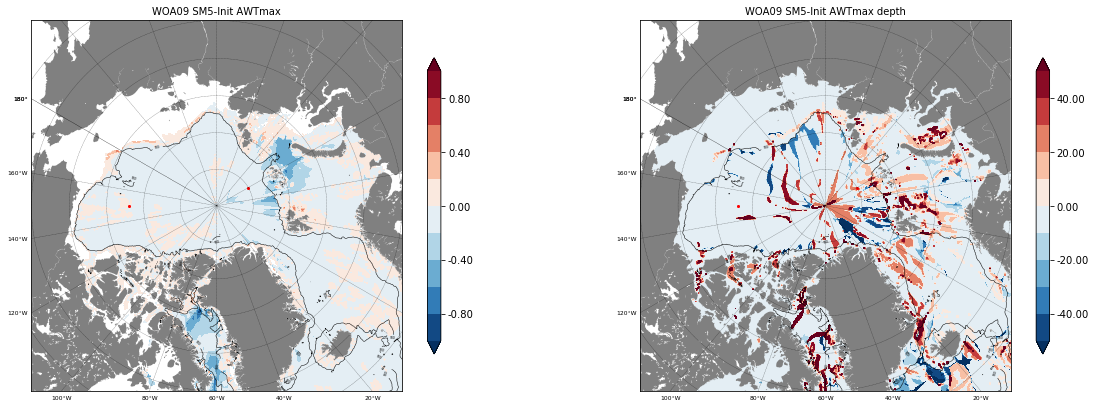

In [156]:
plt.figure(figsize=(20,15))

plt.subplot(221)
lcnt=11  ; cnt=0.2
vmin=-1. ; vmax=1.
contours=np.arange(lcnt)*cnt+vmin
limits=[vmin,vmax]

Arc_Bat(ztype='isol500')
m=Arc_plot(np.array(ds_woa09_full.nav_lon),np.array(ds_woa09_full.nav_lat),np.array(temp_map5-temp_map),\
           contours,limits,zmy_cblab=contours,zmy_cmap='RdBu_r')
plt.title('WOA09 SM5-Init AWTmax',fontsize=10)

plt.subplot(222)
lcnt=11 ; cnt=10
vmin=-50. ; vmax=50.
contours=np.arange(lcnt)*cnt+vmin
limits=[vmin,vmax]

Arc_Bat(ztype='isol500')
m=Arc_plot(np.array(ds_woa09_full.nav_lon),np.array(ds_woa09_full.nav_lat),np.array(depth_map5-depth_map),\
           contours,limits,zmy_cblab=contours,zmy_cmap='RdBu_r')
plt.title('WOA09 SM5-Init AWTmax depth',fontsize=10)


Text(0.5, 1.0, 'WOA09 SM10-Init AWTmax depth')

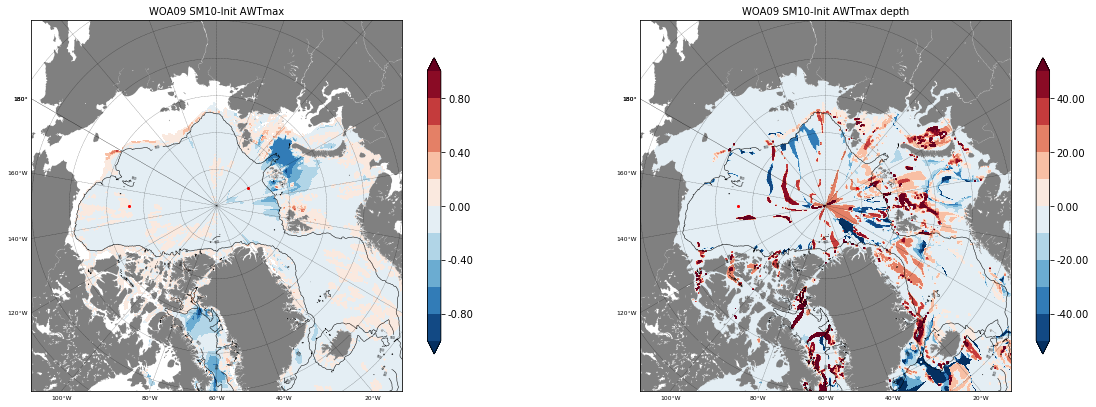

In [155]:
plt.figure(figsize=(20,15))

plt.subplot(221)
lcnt=11  ; cnt=0.2
vmin=-1. ; vmax=1.
contours=np.arange(lcnt)*cnt+vmin
limits=[vmin,vmax]

Arc_Bat(ztype='isol500')
m=Arc_plot(np.array(ds_woa09_full.nav_lon),np.array(ds_woa09_full.nav_lat),np.array(temp_map10-temp_map),\
           contours,limits,zmy_cblab=contours,zmy_cmap='RdBu_r')
plt.title('WOA09 SM10-Init AWTmax',fontsize=10)

plt.subplot(222)
lcnt=11 ; cnt=10.
vmin=-50. ; vmax=50.
contours=np.arange(lcnt)*cnt+vmin
limits=[vmin,vmax]

Arc_Bat(ztype='isol500')
m=Arc_plot(np.array(ds_woa09_full.nav_lon),np.array(ds_woa09_full.nav_lat),np.array(depth_map10-depth_map),\
           contours,limits,zmy_cblab=contours,zmy_cmap='RdBu_r')
plt.title('WOA09 SM10-Init AWTmax depth',fontsize=10)


# Now compute the heat content from the surface down to 1000m

In [127]:
rcp=3991.86795711963  ; rho0=1026.
# Level 46 corresponds to ~1000m depth
# Heat content vertically integrated: Units [GJ/m2] 
facu=1e-9
Tup1000=(ds_woa09_full['votemper'][0:46,:,:]*ds_cfg['e3t_0'][0,0:46,:,:]*rho0*rcp*facu).sum(dim='z')
Tup1000_sm5=(ds_woa09_full['votemper_sm5'][0:46,:,:]*ds_cfg['e3t_0'][0,0:46,:,:]*rho0*rcp*facu).sum(dim='z')
Tup1000_sm10=(ds_woa09_full['votemper_sm10'][0:46,:,:]*ds_cfg['e3t_0'][0,0:46,:,:]*rho0*rcp*facu).sum(dim='z')

Text(0.5, 1.0, 'WOA09 SM10-SM5 < 1000m [GJ/m2]')

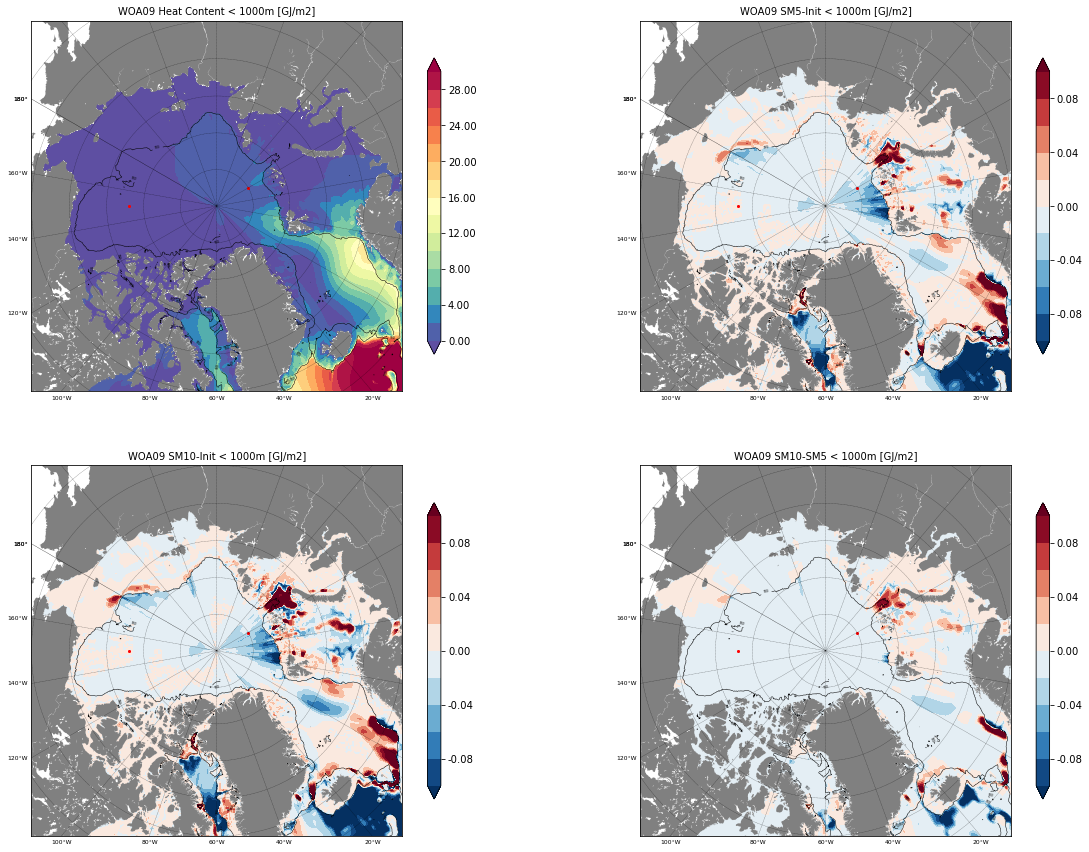

In [157]:
plt.figure(figsize=(20,15))

plt.subplot(221)
lcnt=16  ; cnt=2.
vmin=0. ; vmax=30.
contours=np.arange(lcnt)*cnt+vmin
limits=[vmin,vmax]

Hct_init=xr.where(tmask2D==0.,np.nan,Tup1000)
Arc_Bat(ztype='isol500')
m=Arc_plot(np.array(ds_woa09_full.nav_lon),np.array(ds_woa09_full.nav_lat),np.array(Hct_init),\
           contours,limits,zmy_cblab=contours,zmy_cmap='Spectral_r')
plt.title('WOA09 Heat Content < 1000m [GJ/m2]',fontsize=10)

plt.subplot(222)
lcnt=11  ; cnt=0.02
vmin=-0.1 ; vmax=0.1
contours=np.arange(lcnt)*cnt+vmin
limits=[vmin,vmax]

Arc_Bat(ztype='isol500')
Diff_sm5=xr.where(tmask2D==0.,np.nan, (Tup1000_sm5-Tup1000))
m=Arc_plot(np.array(ds_woa09_full.nav_lon),np.array(ds_woa09_full.nav_lat),np.array(Diff_sm5),\
           contours,limits,zmy_cblab=contours,zmy_cmap='RdBu_r')
plt.title('WOA09 SM5-Init < 1000m [GJ/m2]',fontsize=10)

plt.subplot(223)
lcnt=11  ; cnt=0.02
vmin=-0.1 ; vmax=0.1
contours=np.arange(lcnt)*cnt+vmin
limits=[vmin,vmax]

Diff_sm10=xr.where(tmask2D==0.,np.nan, (Tup1000_sm10-Tup1000))
Arc_Bat(ztype='isol500')
m=Arc_plot(np.array(ds_woa09_full.nav_lon),np.array(ds_woa09_full.nav_lat),np.array(Diff_sm10),\
           contours,limits,zmy_cblab=contours,zmy_cmap='RdBu_r')
plt.title('WOA09 SM10-Init < 1000m [GJ/m2]',fontsize=10)


plt.subplot(224)
lcnt=11  ; cnt=0.02
vmin=-0.1 ; vmax=0.1
contours=np.arange(lcnt)*cnt+vmin
limits=[vmin,vmax]

Diff_sm10_sm5=xr.where(tmask2D==0.,np.nan, (Tup1000_sm10-Tup1000_sm5))
Arc_Bat(ztype='isol500')
m=Arc_plot(np.array(ds_woa09_full.nav_lon),np.array(ds_woa09_full.nav_lat),np.array(Diff_sm10_sm5),\
           contours,limits,zmy_cblab=contours,zmy_cmap='RdBu_r')
plt.title('WOA09 SM10-SM5 < 1000m [GJ/m2]',fontsize=10)

# Plot on a map the mooring location

In [19]:
bx_SVAL={'name':'SVA','lon_min':325,'lon_max':325,'lat_min':350,'lat_max':350,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_BANN={'name':'BAN','lon_min':347,'lon_max':347,'lat_min':400,'lat_max':400,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_AANN={'name':'AAN','lon_min':354,'lon_max':354,'lat_min':425,'lat_max':425,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_KARA={'name':'KAR','lon_min':355,'lon_max':355,'lat_min':450,'lat_max':450,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_ULAP={'name':'ULA','lon_min':364,'lon_max':364,'lat_min':478,'lat_max':478,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_LAPT={'name':'LAP','lon_min':355,'lon_max':355,'lat_min':500,'lat_max':500,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_BGYR={'name':'BFG','lon_min':200,'lon_max':200,'lat_min':500,'lat_max':500,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}
bx_GINS={'name':'GIN','lon_min':355,'lon_max':355,'lat_min':310,'lat_max':310,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}
bx_MIKE={'name':'MIB','lon_min':356,'lon_max':356,'lat_min':237,'lat_max':237,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}

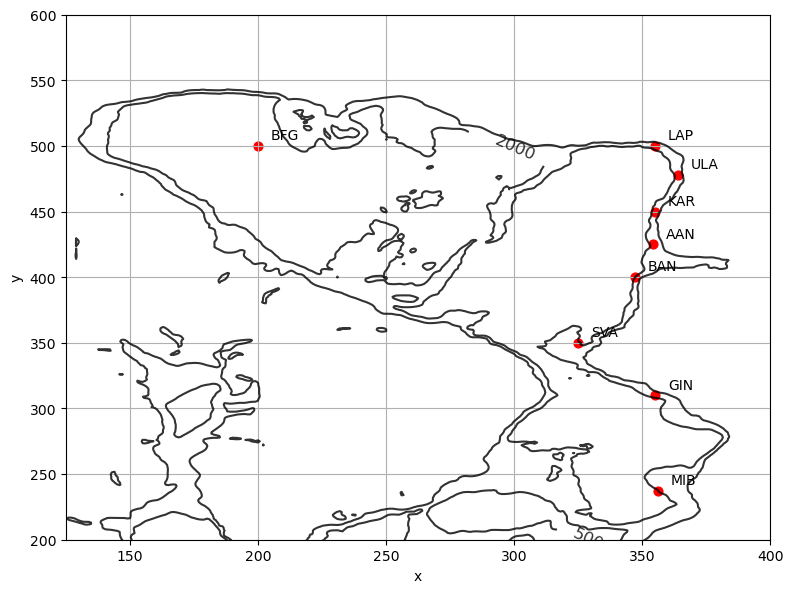

In [20]:
plt.figure(figsize=(20,15))
plt.subplot(221)
CS=fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.8)
plt.clabel(CS,fontsize=12)
plt.ylim([200,600])
plt.xlim([125,400])
All_box=[bx_SVAL,bx_BANN,bx_AANN,bx_KARA,bx_ULAP,bx_LAPT,bx_BGYR,bx_GINS,bx_MIKE]
for box in All_box:
    plt.scatter(box['lon_min'],box['lat_min'],40,marker='o', color='r')
    plt.text(box['lon_min']+5,box['lat_min']+5,box['name'])
plt.grid(True)